In [41]:
!pip install yfinance backtesting pandas numpy matplotlib

In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy


In [45]:
ticker = "RELIANCE.NS"
data = yf.download(ticker, start="2018-01-01", end="2023-12-31")

# --- FIX: Flatten columns if MultiIndex ---
if isinstance(data.columns, pd.MultiIndex):
    data = data.xs(ticker, axis=1, level=1, drop_level=True)

# --- FIX: Ensure correct column names ---
data = data.rename(columns=lambda x: x.capitalize())

# --- FIX: Keep only required columns ---
required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[[col for col in required_cols if col in data.columns]]

# --- FIX: Ensure index is DatetimeIndex ---
if not isinstance(data.index, pd.DatetimeIndex):
    data = data.reset_index()
    if 'Date' in data.columns:
        data = data.set_index('Date')

print(data.head())


[*********************100%***********************]  1 of 1 completed

Price             Open        High         Low       Close    Volume
Date                                                                
2018-01-01  417.465360  417.465360  410.588304  411.606293   9453202
2018-01-02  413.076703  416.040184  410.090601  412.239685   9499419
2018-01-03  418.505979  418.958435  413.099338  413.891113  13507800
2018-01-04  415.406771  417.058186  414.298297  416.379517   9008932
2018-01-05  417.058216  419.365649  416.356925  417.714233   7441284


In [47]:
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()

def RSI(values, n=14):
    delta = pd.Series(values).diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(n).mean()
    avg_loss = loss.rolling(n).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

class MeanReversionStrategy(Strategy):
    bb_period = 20
    bb_std = 2
    rsi_period = 14
    rsi_oversold = 30
    rsi_overbought = 70
    trend_filter_period = 200
    stop_loss_pct = 0.03
    
    def init(self):
        close = self.data.Close
        self.sma = self.I(SMA, close, self.bb_period)
        std = self.I(lambda x: pd.Series(x).rolling(self.bb_period).std(), close)
        self.upper_band = self.sma + (std * self.bb_std)
        self.lower_band = self.sma - (std * self.bb_std)
        self.rsi = self.I(RSI, close, self.rsi_period)
        self.trend_filter = self.I(SMA, close, self.trend_filter_period)
        
    def next(self):
        price = self.data.Close[-1]
        in_sideways_market = abs(price - self.trend_filter[-1]) < 0.02 * price
        if in_sideways_market:
            if (price < self.lower_band[-1]) and (self.rsi[-1] < self.rsi_oversold):
                if not self.position:
                    sl_price = price * (1 - self.stop_loss_pct)
                    self.buy(sl=sl_price)
            elif (price > self.upper_band[-1]) and (self.rsi[-1] > self.rsi_overbought):
                if not self.position:
                    sl_price = price * (1 + self.stop_loss_pct)
                    self.sell(sl=sl_price)
        if self.position:
            if self.position.is_long and price > self.sma[-1]:
                self.position.close()
            elif self.position.is_short and price < self.sma[-1]:
                self.position.close()


In [49]:
bt = Backtest(data, MeanReversionStrategy, cash=100000, commission=0.001, exclusive_orders=True)
stats = bt.run()
print(stats)


Backtest.run:   0%|          | 0/1281 [00:00<?, ?bar/s]

Start                     2018-01-01 00:00:00
End                       2023-12-29 00:00:00
Duration                   2188 days 00:00:00
Exposure Time [%]                     2.09318
Equity Final [$]                  99775.70698
Equity Peak [$]                  102511.77973
Commissions [$]                     797.98456
Return [%]                           -0.22429
Buy & Hold Return [%]               169.93659
Return (Ann.) [%]                     -0.0382
Volatility (Ann.) [%]                   2.458
CAGR [%]                             -0.02586
Sharpe Ratio                         -0.01554
Sortino Ratio                        -0.01998
Calmar Ratio                         -0.00758
Alpha [%]                            -0.41072
Beta                                   0.0011
Max. Drawdown [%]                    -5.04013
Avg. Drawdown [%]                    -3.36985
Max. Drawdown Duration     1414 days 00:00:00
Avg. Drawdown Duration      538 days 00:00:00
# Trades                          

In [51]:
# If using backtesting.py, get the equity curve and returns
equity_curve = stats['_equity_curve']['Equity'].values
dates = stats['_equity_curve'].index
returns = stats['_equity_curve']['Equity'].pct_change().dropna().values


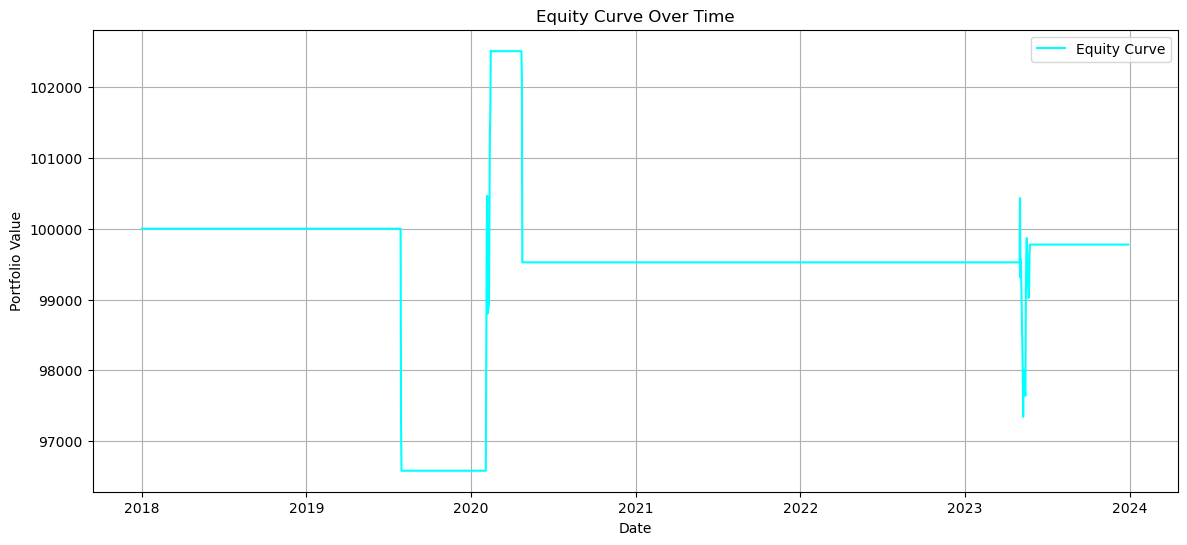

In [53]:
plt.figure(figsize=(14, 6))
plt.plot(dates, equity_curve, label='Equity Curve', color='cyan')
plt.title('Equity Curve Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


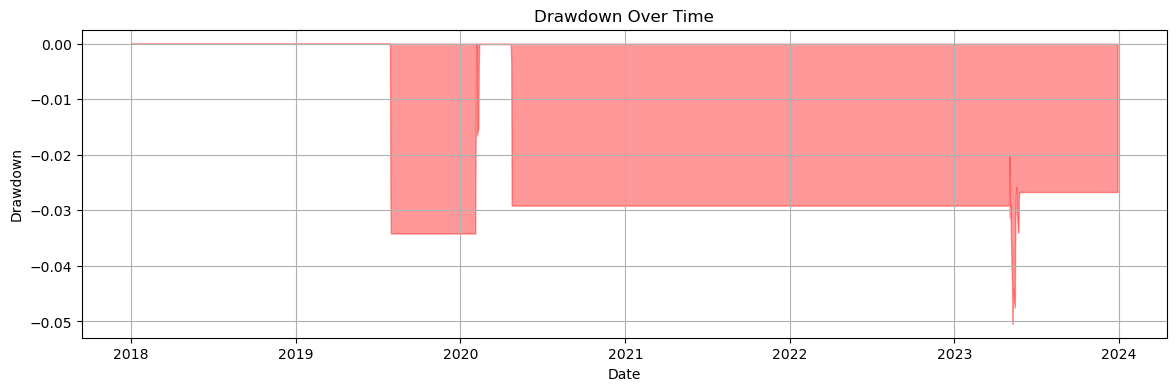

In [55]:
running_max = np.maximum.accumulate(equity_curve)
drawdown = (equity_curve - running_max) / running_max
plt.figure(figsize=(14, 4))
plt.fill_between(dates, drawdown, color='red', alpha=0.4)
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()


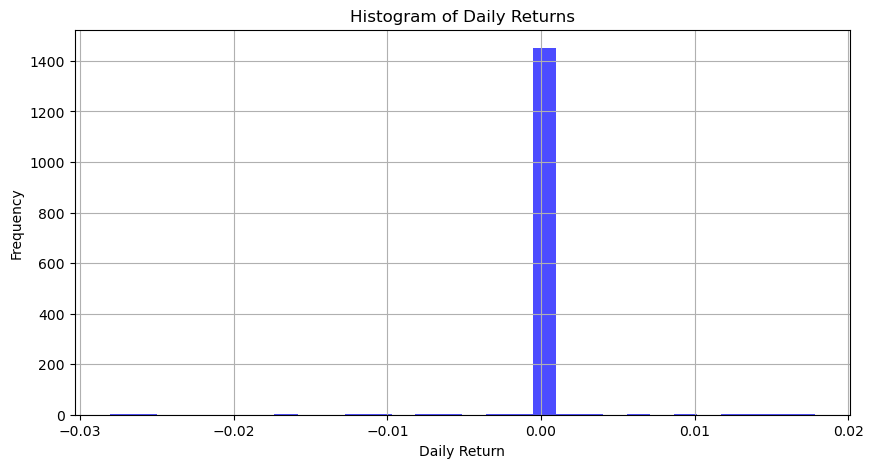

In [57]:
plt.figure(figsize=(10, 5))
plt.hist(returns, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


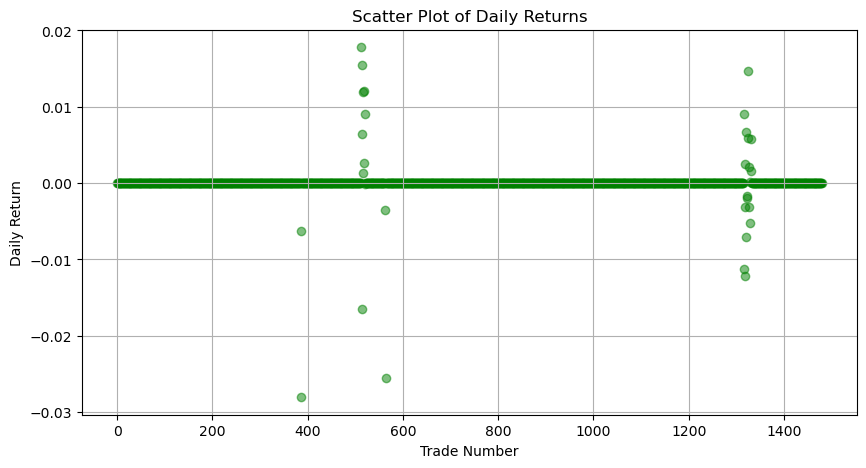

In [59]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(returns)), returns, alpha=0.5, color='green')
plt.title('Scatter Plot of Daily Returns')
plt.xlabel('Trade Number')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()


In [61]:
num_trades = len(returns)
win_trades = returns > 0
cumulative_return = (np.prod(1 + returns) - 1) * 100
annualized_return = ((1 + cumulative_return / 100) ** (252 / num_trades) - 1) * 100
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
rf = 0.01 / 252  # daily risk-free rate
neg_returns = returns[returns < 0]
downside_std = np.std(neg_returns) if len(neg_returns) > 0 else np.nan
sortino_ratio = (np.mean(returns) - rf) / downside_std * np.sqrt(252) if downside_std > 0 else np.nan
max_drawdown = drawdown.min()
win_rate = np.sum(win_trades) / num_trades * 100

metrics = pd.DataFrame({
    'Metric': [
        'Cumulative Return',
        'Annualized Return',
        'Sharpe Ratio',
        'Sortino Ratio',
        'Maximum Drawdown',
        'Win Rate'
    ],
    'Value': [
        f'{cumulative_return:.2f}%',
        f'{annualized_return:.2f}%',
        f'{sharpe_ratio:.2f}',
        f'{sortino_ratio:.2f}' if not np.isnan(sortino_ratio) else 'N/A',
        f'{max_drawdown:.2%}',
        f'{win_rate:.2f}%'
    ]
})

print('\nPerformance Metrics Table:')
print(metrics.to_string(index=False))



Performance Metrics Table:
           Metric  Value
Cumulative Return -0.22%
Annualized Return -0.04%
     Sharpe Ratio  -0.00
    Sortino Ratio  -0.07
 Maximum Drawdown -5.04%
         Win Rate  1.15%
